In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

In [9]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [10]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

In [11]:
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
import pandas as pd
import glob

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from cycler import cycler

In [12]:
# TEMPO FOV
lon_min = -168
lon_max = -13
lat_min = 14
lat_max = 73

df = pd.read_csv('https://planet4589.org/space/gcat/tsv/launch/launch.tsv', sep='\t',)
sites_df = pd.read_csv('https://planet4589.org/space/gcat/tsv/tables/sites.tsv', sep='\t')

def clean_and_parse_date(date_str):
    try:
        # Remove invalid characters like "?"
        cleaned_date = date_str.replace('?', '').strip()

        # Check if the format includes seconds
        if len(cleaned_date.split()) == 4 and ':' in cleaned_date:
            return pd.to_datetime(cleaned_date, format='%Y %b %d %H%M:%S')
        # Check if the format includes hours and minutes
        elif len(cleaned_date.split()) == 4:
            return pd.to_datetime(cleaned_date, format='%Y %b %d %H%M')
        # Check if it's just year, month, day
        elif len(cleaned_date.split()) == 3:
            return pd.to_datetime(cleaned_date, format='%Y %b %d')
        # Check if it's just year, month
        elif len(cleaned_date.split()) == 2 and 'Q' not in cleaned_date:
            return pd.to_datetime(cleaned_date, format='%Y %b')
        # Check if it's just year, quarter
        elif len(cleaned_date.split()) == 2 and 'Q' in cleaned_date:
            # Extract the year for quarters
            return int(cleaned_date.split()[0])  # Return the year only
        # Check if it's just year
        elif len(cleaned_date.split()) == 1:
            return pd.to_datetime(cleaned_date, format='%Y')
        else:
            return np.nan  # Return NaN for invalid entries
    except Exception:
        return np.nan

# Apply the cleaning and parsing function
df['timestamp'] = df['Launch_Date'].apply(clean_and_parse_date)
df.dropna(subset=['timestamp'], inplace=True)
# set timestamp index
df.set_index('timestamp', inplace=True)
df.index = pd.DatetimeIndex(df.index)
df.sort_index(inplace=True)

# only launches during TEMPO mission
recent_df = df.loc['2023-08-01':'2025-08-01']

# given the Launch_Site, find the corresponding lat and lon
def get_lat(site):
    try:
        return sites_df[sites_df['#Site'] == site]['Latitude'].values[0]
    except Exception:
        return np.nan
    
def get_lon(site):
    try:
        return sites_df[sites_df['#Site'] == site]['Longitude'].values[0]
    except Exception:
        return np.nan

# get the lat and lon for each launch site
recent_df['lat'] = recent_df['Launch_Site'].apply(get_lat).astype(float)
recent_df['lon'] = recent_df['Launch_Site'].apply(get_lon).astype(float)

tempo_df = recent_df[(recent_df['lon'] > lon_min) & (recent_df['lon'] < lon_max) & (recent_df['lat'] > lat_min) & (recent_df['lat'] < lat_max)]
# recent_df[(recent_df['lon'] > lon_min) & (recent_df['lon'] < lon_max) & (recent_df['lat'] > lat_min) & (recent_df['lat'] < lat_max)].tail(10)
# check if files were downloaded for specific launch
def check_files(launch):
    files = glob.glob(f'/home/jpalmo/fs09/Datasets/TEMPO/L3/NO2/TEMPO_NO2_L3_V03*{launch}*')
    return len(files) > 0
# make new dataframe only where files are available
for t, row in tempo_df.iterrows():
    hour_str = t.strftime('%Y%m%dT%H')
    # print(hour_str, "-----", check_files(hour_str))
    tempo_df.loc[t, 'files'] = check_files(hour_str)

tempo_df = tempo_df[tempo_df['files'] == True]

tempo_df.sort_index(inplace=True)

tempo_gdf = gpd.GeoDataFrame(tempo_df, geometry=gpd.points_from_xy(tempo_df.lon, tempo_df.lat))

tempo_gdf.crs = {'init': 'epsg:4326'}

In [16]:
# remove tempo_gdf rows that are in detections_gdf (must match lat and lon and timestamp)
# Create a merge key combining lat, lon and timestamp for both dataframes
tempo_gdf['merge_key'] = tempo_gdf.apply(lambda row: f"{row.lat}_{row.lon}_{row.name}", axis=1)
initial_detections_df['merge_key'] = initial_detections_df.apply(lambda row: f"{row.lat}_{row.lon}_{row.name}", axis=1)

# Keep only rows from tempo_gdf that are not in detections_df
tempo_gdf = tempo_gdf[~tempo_gdf['merge_key'].isin(initial_detections_df['merge_key'])]
# remove duplicates based on timing
tempo_gdf = tempo_gdf[~tempo_gdf.index.duplicated(keep='first')]

# Drop the temporary merge key column
tempo_gdf = tempo_gdf.drop('merge_key', axis=1)
tempo_gdf['count'] = 1
tempo_gdf_grouped = tempo_gdf.groupby(['lat', 'lon', 'Launch_Site']).count().reset_index()
tempo_gdf_grouped = tempo_gdf_grouped[['lat', 'lon', 'Launch_Site', 'count']]
tempo_gdf_grouped = gpd.GeoDataFrame(tempo_gdf_grouped, geometry=gpd.points_from_xy(tempo_gdf_grouped.lon, tempo_gdf_grouped.lat))

In [17]:
initial_detections_df['count'] = 1
detections_df_grouped = initial_detections_df.groupby(['lat', 'lon', 'Launch_Site']).count().reset_index()
detections_df_grouped = detections_df_grouped[['lat', 'lon', 'Launch_Site', 'count']]
detections_gdf_grouped = gpd.GeoDataFrame(detections_df_grouped, geometry=gpd.points_from_xy(detections_df_grouped.lon, detections_df_grouped.lat))

In [18]:
tempo_gdf_grouped[tempo_gdf_grouped['Launch_Site'] == 'CC']['count'] = tempo_gdf_grouped[tempo_gdf_grouped['Launch_Site'] == 'CC']['count'] + tempo_gdf_grouped[tempo_gdf_grouped['Launch_Site'] == 'SPFLA']['count']
detections_gdf_grouped[detections_gdf_grouped['Launch_Site'] == 'CC']['count'] = detections_gdf_grouped[detections_gdf_grouped['Launch_Site'] == 'CC']['count'] + detections_gdf_grouped[detections_gdf_grouped['Launch_Site'] == 'SPFLA']['count']

In [19]:
detections_gdf_grouped = detections_gdf_grouped[detections_gdf_grouped['Launch_Site'] != 'SPFLA']

# Figure S1

In [20]:
#set color to tab20
sns.set_palette("tab20")

STB 2    0.363636
Name: count, dtype: float64
CC 4    0.202703
Name: count, dtype: float64
KSC 5    0.227273
Name: count, dtype: float64
VSFBS 12    0.146341
Name: count, dtype: float64


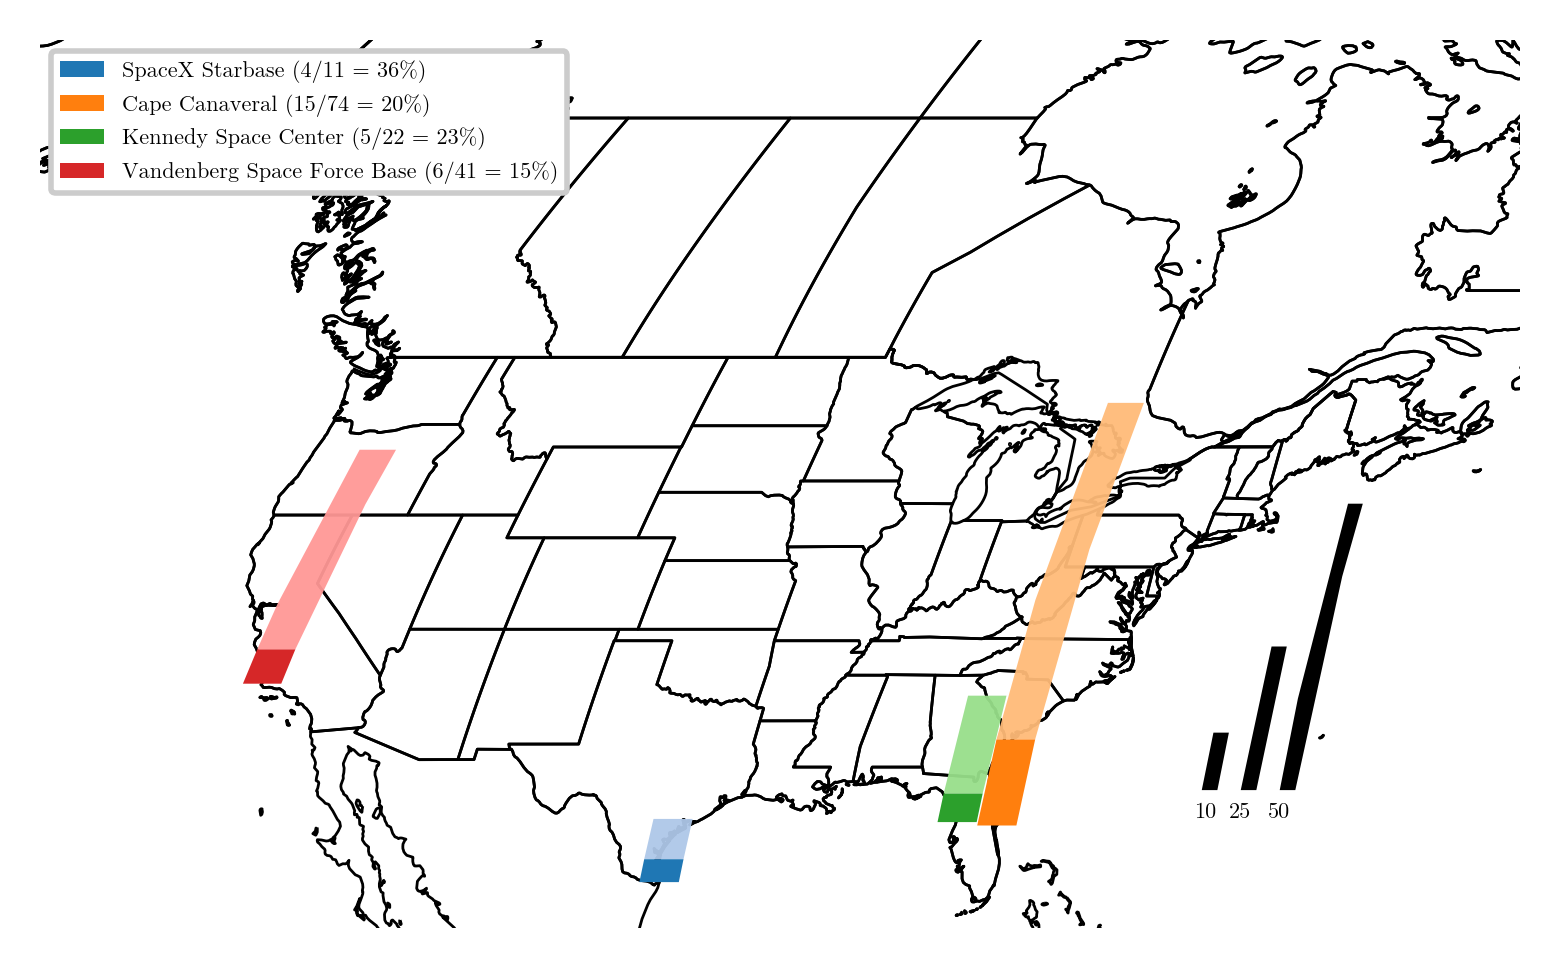

In [22]:
# USA bounding box
lon_min = -128
lon_max = -65
lat_min = 24
lat_max = 50

# plot the locations of the launches on US map with TEMPO FOV, using geopandas and cartopy
fig = plt.figure(figsize=(4, 4), dpi=400)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add the background map -- just country outlines
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5)

# Add the FOV
ax.set_extent([lon_min, lon_max, lat_min, lat_max+10])

# Add the launch sites, with bar size corresponding to number of launches
site_dict = {'CC': 'Cape Canaveral', 'KSC': 'Kennedy Space Center', 'VSFBS': 'Vandenberg Space Force Base', 'STB': 'SpaceX Starbase', 'WS': 'White Sands', 'SPAM': 'Spaceport America', 'SPFLA': 'Space Florida'}

# set colormap to tab20
# Use the 'tab20' colormap for the global color cycle
colors = plt.cm.tab20.colors  # Extract colors from the 'tab20' colormap
plt.rc('axes', prop_cycle=cycler('color', colors))

for i,row in detections_gdf_grouped.iterrows():
    tmp_full = tempo_gdf_grouped.loc[tempo_gdf_grouped['Launch_Site'] == row['Launch_Site']]
    # Compute numerator and denominator
    num = int(row["count"])
    den = int(tmp_full["count"].sum() + num)  # or whatever your denominator is

    # Calculate percent
    percent = round((num / den) * 100)

    # Build label string
    label = f"{num}/{den} = {percent}%"

    if row['lon'] == -80.6041:
        ax.bar(row['lon']-2, bottom=row['lat'], height=row['count']/4, width=2, zorder=2, alpha=1, transform=ccrs.PlateCarree(), label=site_dict[row['Launch_Site']]+f" ({label})")
        ax.bar(tmp_full['lon']-2, bottom=tmp_full['lat']+row['count']/4, height=tmp_full['count']/4, width=2,zorder=2, alpha=0.95, transform=ccrs.PlateCarree(),)
        print(row['Launch_Site'], row['count']/(tmp_full['count']+row['count']))
        continue
    ax.bar(row['lon'], bottom=row['lat'], height=row['count']/4,width=2, zorder=2, alpha=1, transform=ccrs.PlateCarree(), label=site_dict[row['Launch_Site']]+f" ({label})")
    ax.bar(tmp_full['lon'], bottom=tmp_full['lat']+row['count']/4,width=2,height=tmp_full['count']/4, zorder=2, alpha=0.95, transform=ccrs.PlateCarree(),)
    print(row['Launch_Site'], row['count']/(tmp_full['count']+row['count']))

ax.legend(fontsize=4, loc='upper left', title_fontsize=6, framealpha=1)

ax.set_axis_off()

# Example bar sizes and labels for the legend
example_sizes = [10, 25, 50,]
for i, size in enumerate(example_sizes):
    start_lon = -70
    ax.bar(
        start_lon + 2*(i), bottom=30, height=size/4,
        alpha=1,
        color='k',
        label=f'{size} launches',
        # align='center',
        zorder=2,
        transform=ccrs.PlateCarree(),
    )
    if i == 0:
        offset = 0.5
    else: 
        offset = 0.7
    ax.text(
        start_lon-offset + 2*(i), 28.6, f"{size}", fontsize=4, horizontalalignment='left',
        verticalalignment='bottom', transform=ccrs.PlateCarree()
    )
# ax.text(
#     start_lon-0.1, 27, f"Count", fontsize=4, horizontalalignment='left',
#     verticalalignment='bottom', transform=ccrs.PlateCarree()
# )

fig.tight_layout()
# save figure
plt.savefig(f'figures/supfig_1.png', dpi=300)